Pobieramy dane. Alternatywnie z zapisanego pliku lokalnie.
Źródło danych: (GPW) https://www.gpw.pl/archiwum-notowan 

In [1]:
import pandas as pd
import numpy as np

# get data
url = 'https://drive.google.com/file/d/1VfvaefBkfg0fvEkDwgBep10Vs3T5egWH/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path)
df['Data'] = pd.to_datetime(df['Data'])
df = df.set_index('Data')

Definicja funkcji RSI

In [2]:
### by Jev //
def rsi(price, n=14):
    # calculate price gain with previous day, first row nan is filled with 0
    gain = (price-price.shift(1)).fillna(0) 
    def rsiCalc(p):
        # subfunction for calculating rsi for one lookback period
        avgGain = p[p>0].sum()/n
        avgLoss = -p[p<0].sum()/n 
        rs = avgGain/avgLoss
        return 100 - 100/(1+rs)

    # run for all periods with rolling_apply
    return gain.rolling(n).apply(rsiCalc) 

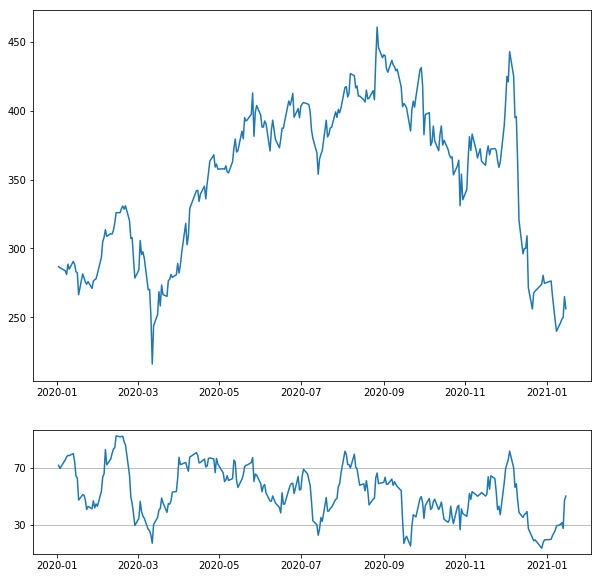

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec 

mask = df.index > '2020-01-01'
df['rsi'] = rsi(df['close'])

# create grid for different subplots
spec = gridspec.GridSpec(ncols=1, nrows=2, width_ratios=[1],wspace=0.5,hspace=0.2, height_ratios=[3,1])

# create a figure 
fig = plt.figure(figsize=[10,10]) 
ax0 = fig.add_subplot(spec[0]) 
ax1 = fig.add_subplot(spec[1]) 
ax1.set_yticks([30, 70])

ax0.plot(df['close'][mask])
ax1.plot(df['rsi'][mask])
ax1.yaxis.grid(True)

Przykładowa strategia RSI
RSI 14 / 30 / 70

In [5]:
for l in range(10, 20, 1):
    dr = df[df.index > '2019-01-01']
    dr['rsi'] = rsi(dr['close'], l)

    positive_mask = (dr['rsi']>30) & (dr['rsi']<70) 
    buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
    close_buy_mask = positive_mask & ~positive_mask.shift(periods=-1).fillna(False)

    #gain %
    gain = np.sum((dr['close'].loc[close_buy_mask].to_numpy()-dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)])/dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)])

    print('len:%d  gain:%.2f%%  num_trans:%d' %(l, 100*gain, np.sum(close_buy_mask)))

len:10  gain:15.41%  num_trans:52
len:11  gain:-3.16%  num_trans:39
len:12  gain:17.98%  num_trans:33
len:13  gain:36.47%  num_trans:33
len:14  gain:26.54%  num_trans:33
len:15  gain:31.85%  num_trans:29
len:16  gain:48.43%  num_trans:29
len:17  gain:39.60%  num_trans:23
len:18  gain:47.89%  num_trans:22
len:19  gain:40.01%  num_trans:21


In [6]:
dr = df[df.index > '2019-01-01']

for l in range(10, 100, 10):

    dr['avg'] = df['close'].rolling(window=l).mean()[df.index > '2019-01-01']

    positive_mask = (dr['close'] > dr['avg']) 
    buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
    close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)

    #gain %
    gain = np.sum(dr['close'].loc[close_buy_mask].to_numpy() / dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)] - 1)

    print('len:%d  gain:%.2f%%  num_trans:%d' %(l, 100*gain, np.sum(close_buy_mask)))

len:10  gain:67.64%  num_trans:42
len:20  gain:19.86%  num_trans:32
len:30  gain:32.51%  num_trans:31
len:40  gain:48.78%  num_trans:22
len:50  gain:50.68%  num_trans:15
len:60  gain:49.56%  num_trans:15
len:70  gain:46.61%  num_trans:13
len:80  gain:54.10%  num_trans:13
len:90  gain:82.94%  num_trans:8


In [7]:
dr = df[df.index > '2019-01-01']
maxgain = 0
for len_slow in range(10, 100, 10):
    for len_fast in range(5, 100, 5):
        if len_fast >= len_slow:
            continue

        dr['avg_fast'] = df['close'].rolling(window=len_fast).mean()[df.index > '2019-01-01']
        dr['avg_slow'] = df['close'].rolling(window=len_slow).mean()[df.index > '2019-01-01']

        positive_mask = (dr['avg_fast'] > dr['avg_slow']) 
        buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
        close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)

        #gain %
        gain = np.sum(dr['close'].loc[close_buy_mask].to_numpy() / dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)] - 1)
        if gain > maxgain:
            maxgain = gain
            print('New max! len_slow:%d  len_fast:%d  gain:%.2f%%  num_trans:%d' %(len_slow, len_fast, 100*gain, np.sum(close_buy_mask)))

New max! len_slow:10  len_fast:5  gain:33.18%  num_trans:29
New max! len_slow:40  len_fast:10  gain:35.07%  num_trans:7
New max! len_slow:50  len_fast:10  gain:36.56%  num_trans:6
New max! len_slow:50  len_fast:40  gain:49.81%  num_trans:7
New max! len_slow:60  len_fast:30  gain:63.30%  num_trans:3
New max! len_slow:60  len_fast:40  gain:82.69%  num_trans:3
New max! len_slow:60  len_fast:50  gain:85.35%  num_trans:6
New max! len_slow:70  len_fast:45  gain:90.83%  num_trans:2
New max! len_slow:80  len_fast:60  gain:98.96%  num_trans:1
New max! len_slow:80  len_fast:65  gain:99.95%  num_trans:1
New max! len_slow:80  len_fast:70  gain:108.86%  num_trans:1


New max! len_slow:60  len_fast:40  gain:82.69%  num_trans:3


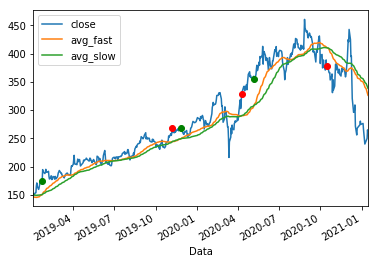

In [8]:
maxgain = 0
len_fast = 40
len_slow = 60
dr['avg_fast'] = df['close'].rolling(window=len_fast).mean()[df.index > '2019-01-01']
dr['avg_slow'] = df['close'].rolling(window=len_slow).mean()[df.index > '2019-01-01']

positive_mask = (dr['avg_fast'] > dr['avg_slow']) 
buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)

#gain %
gain = np.sum(dr['close'].loc[close_buy_mask].to_numpy() / dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)] - 1)
if gain > maxgain:
    maxgain = gain
    print('New max! len_slow:%d  len_fast:%d  gain:%.2f%%  num_trans:%d' %(len_slow, len_fast, 100*gain, np.sum(close_buy_mask)))

#wykres
tmp = pd.concat([dr[['close', 'avg_fast', 'avg_slow']], pd.DataFrame(buy_mask, columns=['buy']).replace({False:np.nan, True:1}), pd.DataFrame(close_buy_mask, columns=['close_buy']).replace({False:np.nan, True:1})], axis=1)
tmp['buy'] = tmp['buy'] * tmp['close']
tmp['close_buy'] = tmp['close_buy'] * tmp['close']
tmp[['close', 'avg_fast', 'avg_slow']].plot()
tmp['close_buy'].plot(style='or')
tmp['buy'].plot(style='og')    

In [9]:
# transakcje LONG
newdf = pd.DataFrame(tmp['buy'][~tmp['buy'].isna()])
newdf['close_buy'] = tmp['close_buy'][~tmp['close_buy'].isna()].to_numpy()
newdf['gain%'] = round(100 * (newdf['close_buy'] / newdf['buy'] - 1), 2)
newdf['buy_date'] = tmp.index[~tmp['buy'].isna()]
newdf['close_date'] = tmp.index[~tmp['close_buy'].isna()]
newdf

,buy,close_buy,gain%,buy_date,close_date
Data,,,,,
2019-01-22,174.1,267.5,53.65,2019-01-22,2019-11-07
2019-11-27,268.4,329.0,22.58,2019-11-27,2020-04-09
2020-05-07,355.6,378.6,6.47,2020-05-07,2020-10-16


In [10]:
negative_mask = (dr['avg_fast'] < dr['avg_slow']) 
sell_mask = negative_mask & ~negative_mask.shift(periods=1).fillna(False)
close_sell_mask = ~negative_mask & negative_mask.shift(periods=1).fillna(False)

#gain %
if np.sum(sell_mask) > np.sum(close_sell_mask):
    #sztucznie zamykamy ostatnią transkację ostatniego dnia
    close_sell_mask[-1] = True

gain = np.sum(-(dr['close'].loc[close_sell_mask].to_numpy() / dr['close'].loc[sell_mask].to_numpy() - 1))

print(100*gain)

8.610067273064958


In [11]:
# transakcje SHORT
newdf = pd.DataFrame(tmp['close'][sell_mask])
newdf['close_sell'] = tmp['close'][close_sell_mask].to_numpy()
newdf['gain%'] = round(-100 * (newdf['close_sell'] / newdf['close'] - 1), 2)
newdf['sell_date'] = tmp.index[sell_mask]
newdf['close_date'] = tmp.index[close_sell_mask]
newdf

,close,close_sell,gain%,sell_date,close_date
Data,,,,,
2019-01-02,151.0,174.1,-15.30,2019-01-02,2019-01-22
2019-11-07,267.5,268.4,-0.34,2019-11-07,2019-11-27
2020-04-09,329.0,355.6,-8.09,2020-04-09,2020-05-07
2020-10-16,378.6,256.2,32.33,2020-10-16,2021-01-15


EMA

In [12]:
dr = df[df.index > '2019-01-01']
maxgain = 0
for len_slow in range(10, 100, 10):
    for len_fast in range(5, 100, 5):
        if len_fast >= len_slow:
            continue

        dr['avg_fast'] = df['close'].ewm(halflife=len_fast).mean()[df.index > '2019-01-01']
        dr['avg_slow'] = df['close'].ewm(halflife=len_slow).mean()[df.index > '2019-01-01']

        positive_mask = (dr['avg_fast'] > dr['avg_slow']) 
        buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
        close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)

        #gain %
        gain = np.sum(dr['close'].loc[close_buy_mask].to_numpy() / dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)] - 1)
        if gain > maxgain:
            maxgain = gain
            print('New max! len_slow:%d  len_fast:%d  gain:%.2f%%  num_trans:%d' %(len_slow, len_fast, 100*gain, np.sum(close_buy_mask)))

New max! len_slow:10  len_fast:5  gain:39.05%  num_trans:6
New max! len_slow:20  len_fast:5  gain:53.46%  num_trans:3
New max! len_slow:20  len_fast:15  gain:92.70%  num_trans:1
New max! len_slow:90  len_fast:5  gain:105.18%  num_trans:1


Rozkład normalny przypadkowych zmian

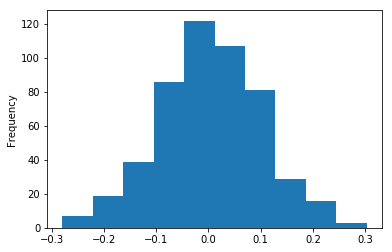

In [22]:
dr = df[df.index>'2019-01-01']

np.random.seed(1) #seed numpy to have same initialized weitghts
random_chng = np.random.normal(0, 0.1, dr.shape[0])

dr['rand_changes'] = random_chng
dr['rand_changes'].plot.hist()

In [24]:
random_close = np.zeros(len(dr))
random_close[0] = dr['close'][0]
for i in range(1, len(random_close)):
    random_close[i] = random_close[i-1] * (1 + random_chng[i])
dr['random_close'] =  random_close
#dr[['close','random_close']].plot()
dr['random_close'].plot(legend=True)

TypeError: 'int' object is not callable

In [ ]:
maxgain = 0
for len_slow in range(10, 100, 10):
    for len_fast in range(5, 100, 5):
        if len_fast >= len_slow:
            continue

        dr['avg_fast'] = dr['random_close'].rolling(window=len_fast).mean()
        dr['avg_slow'] = dr['random_close'].rolling(window=len_slow).mean()

        positive_mask = (dr['avg_fast'] > dr['avg_slow']) 
        buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
        close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)

        #gain %
        gain = np.sum(dr['random_close'].loc[close_buy_mask].to_numpy() / dr['random_close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)] - 1)
        if gain > maxgain:
            maxgain = gain
            print('New max! len_slow:%d  len_fast:%d  gain:%.2f%%  num_trans:%d' %(len_slow, len_fast, 100*gain, np.sum(close_buy_mask)))

In [ ]:
dr = df[df.index > '2019-01-01']
dr.pct_change().fillna(0).plot.hist()

In [ ]:
from pandas.plotting import autocorrelation_plot
#autocorrelation_plot(dr['close'])
autocorrelation_plot(dr['close'].pct_change().fillna(0))